In [1]:
#!pip install folktables

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, 
ACSTravelTime, ACSMobility
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform


# Given the different type of ACS data - find the different clusters and then see which states are are bundle together for the different types of data available -- see if there are certain states that are consistently together

### just looking at income to see how well it works

In [2]:
# Selected states from west coast, east coast, and then some from the middle
# income_features = ['AGEP','COW','SCHL','MAR','OCCP','POBP','RELP','WKHP','SEX','RAC1P', 'ST']



In [16]:
states = [
    "CA", "OR", "WA", "ME", "NY", "NJ", "FL", "VA", "NH", "ND", "SD", "PR", "WY", "CO", "MT", "TX"
]

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')


def acs_type(data_processor): 
    all_data = pd.DataFrame()
    
    for state in states: 
        state_data = data_source.get_data(states=[state], download=True)
                
        state_features, _, _ = data_processor.df_to_numpy(state_data)  # Convert to NumPy arrays
        state_features_df = pd.DataFrame(state_features)  # Convert back to DataFrame for clustering
        state_features_df['ST'] = state  # adding state label
        all_data = pd.concat([all_data, state_features_df], ignore_index=True)
    
    all_data.columns = all_data.columns.astype(str)
    
    # doing PCA so can plot main features later
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(all_data.drop(columns="ST"))
    all_data[['PCA1', 'PCA2']] = principal_components 
    
    # only running model on selected features
    kmeans = KMeans(n_clusters=4)
    all_data['cluster'] = kmeans.fit_predict(all_data.drop(columns="ST"))

    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.scatterplot(
        x='PCA1', 
        y='PCA2',
        hue='cluster',
        style='ST', 
        data = all_data, 
        s=50
    )
    
    # BAR PLOT
    # do additional analysis of the clustering the different states
    st_cluster_count = all_data.value_counts(["ST", "cluster"]).reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(data=st_cluster_count, x="cluster", y="count", hue="ST", dodge=True)
    
    # Enhance the plot
    plt.title("Distribution of Data Points by Cluster and State")
    plt.xlabel("Cluster")
    plt.ylabel("Count of Data Points")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="State")
    plt.tight_layout()
    plt.show()
    
    
    # CORRELATION PLOT
    # Normalize cluster counts to get proportions for each state
    st_cluster_proportions = st_cluster_count.pivot(index="ST", columns="cluster", values="count").fillna(0)
    st_cluster_proportions = st_cluster_proportions.div(st_cluster_proportions.sum(axis=1), axis=0)
    
    # Compute pairwise distances between states based on cluster proportions
    distances = pdist(st_cluster_proportions, metric="euclidean")  # can try cosine for choise of distance
    distance_matrix = pd.DataFrame(
        squareform(distances),
        index=st_cluster_proportions.index,
        columns=st_cluster_proportions.index
    )

    # Visualize the distance matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("State Similarity Based on Cluster Distribution")
    plt.xlabel("State")
    plt.ylabel("State")
    plt.tight_layout()
    plt.show()


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


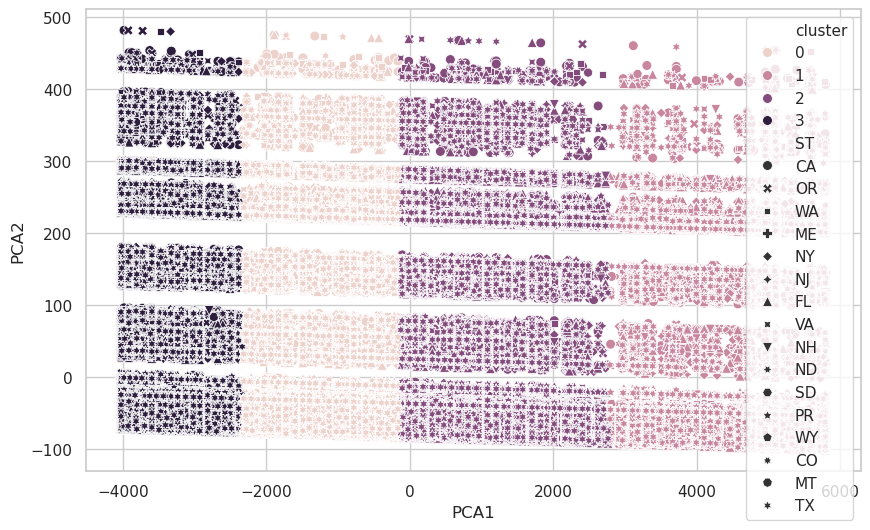

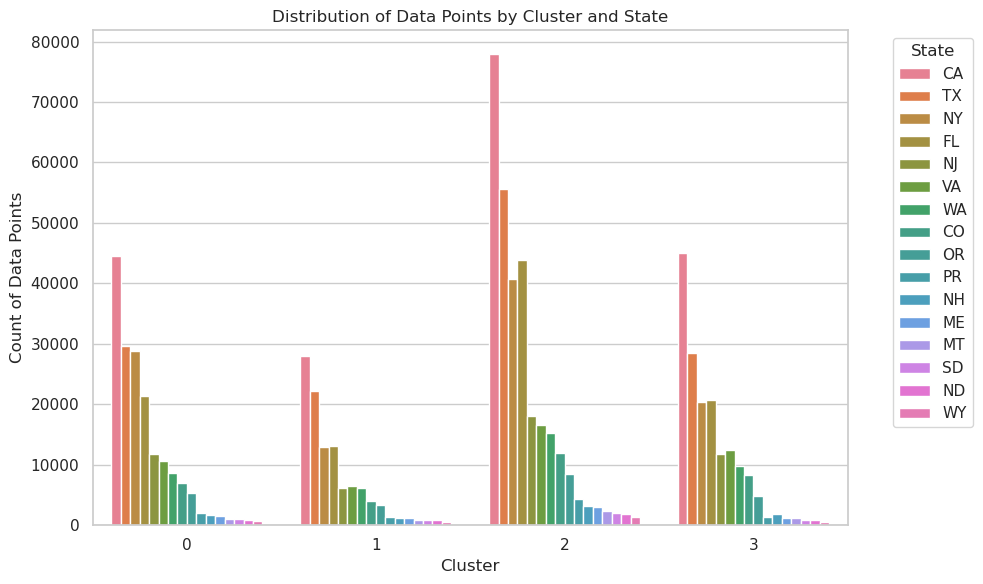

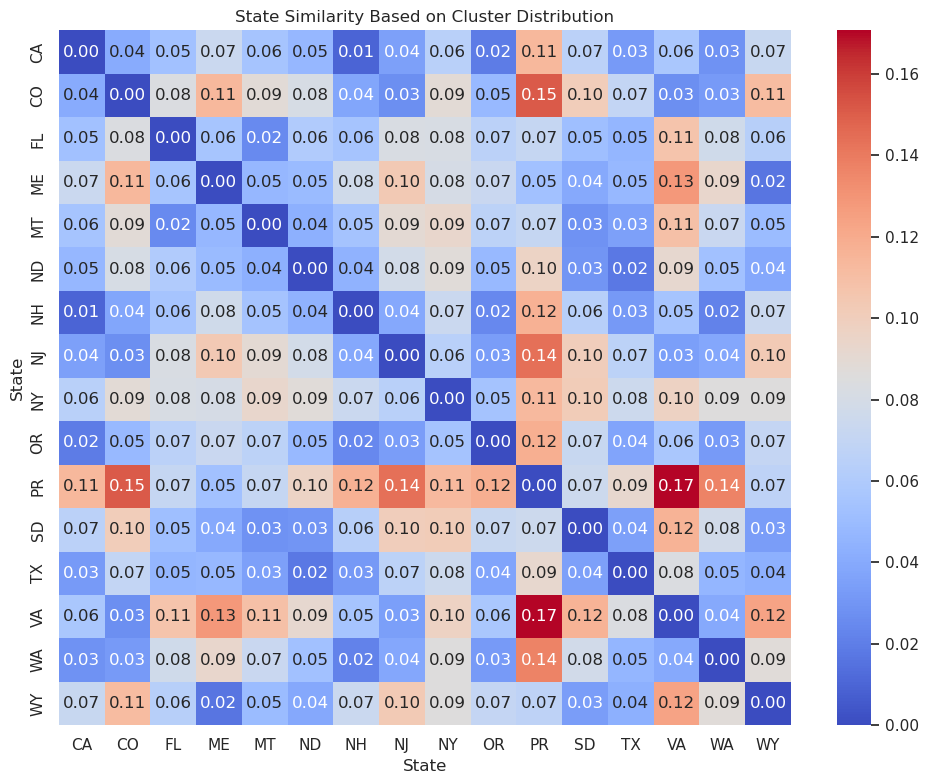

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


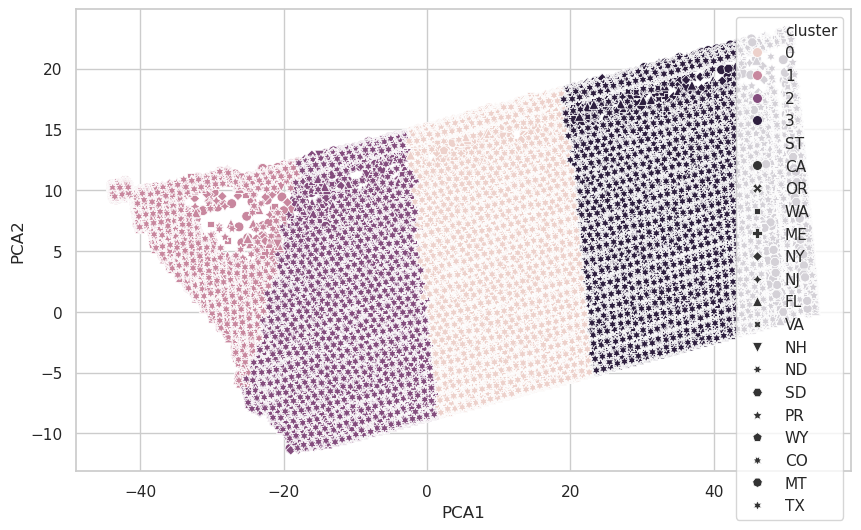

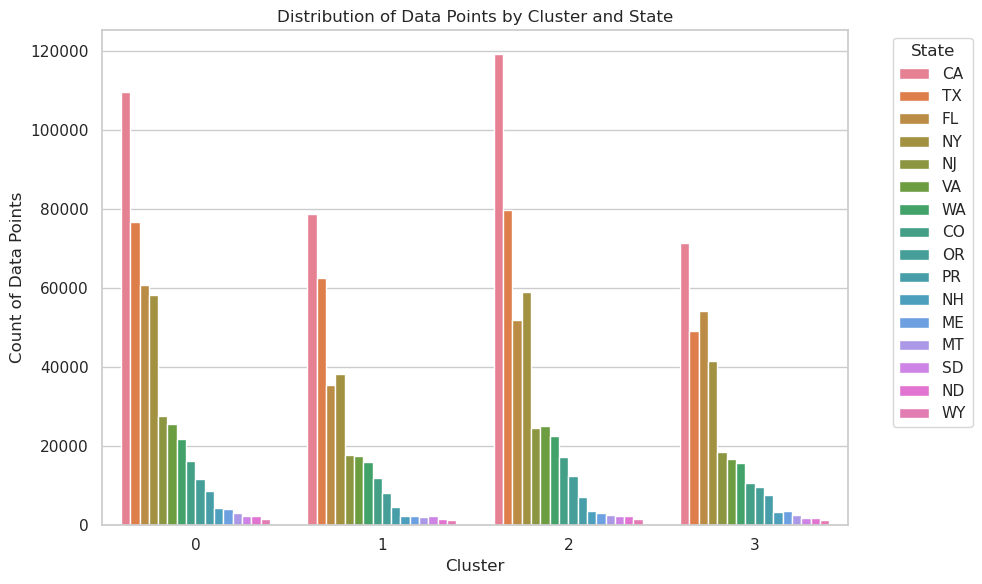

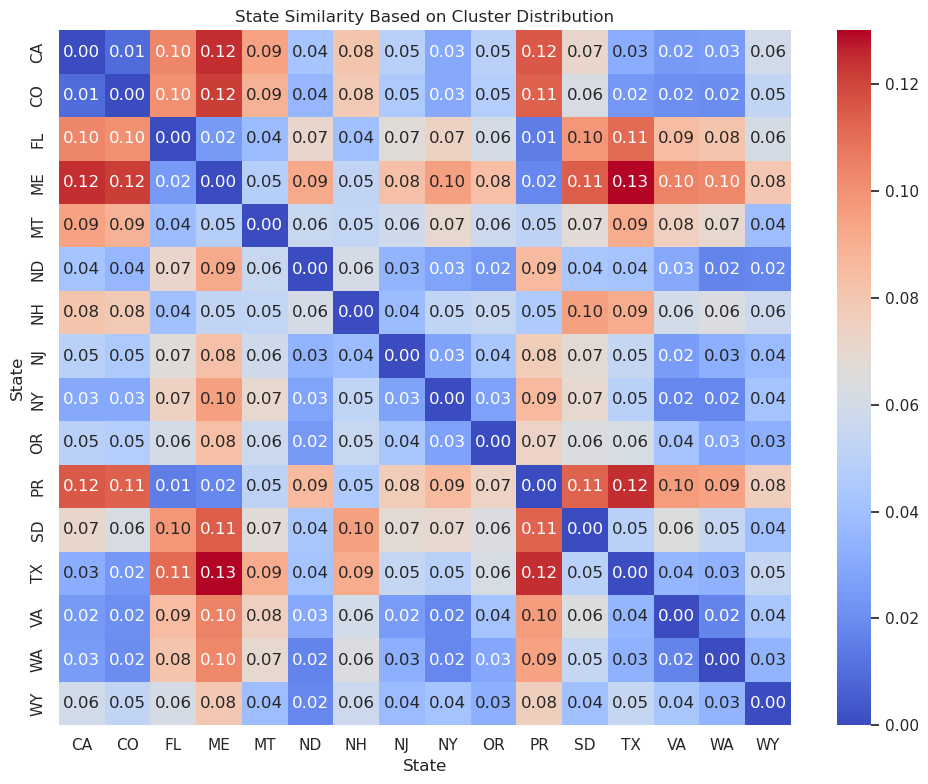

NameError: name 'ACSPublicCoverage' is not defined

In [18]:
acs_type(ACSIncome)
acs_type(ACSEmployment)
acs_type(ACSPublicCoverage)

## Work from Week 6

In [8]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
ca_acs_data = data_source.get_data(states=["CA"], download=True)
ca_features, ca_label, ca_group = ACSIncome.df_to_numpy(ca_acs_data)


pr_acs_data = data_source.get_data(states=["PR"], download=True)
pr_features, pr_label, pr_group = ACSIncome.df_to_numpy(pr_acs_data)

sd_acs_data = data_source.get_data(states=["SD"], download=True)
sd_features, sd_label, sd_group = ACSIncome.df_to_numpy(sd_acs_data)

In [4]:
# Define a helper function to get the specified proportion of data from a dataset.
def get_split(data, labels, groups, proportion):
    n = int(len(data) * proportion)
    indices = np.random.choice(len(data), n, replace=False)
    return data[indices], labels[indices], groups[indices]

# Split proportions for training
split_ratios = [
    {"PR": 0.2, "CA": 0.8},
    {"SD": 0.2, "CA": 0.8},
    {"PR": 0.2, "SD": 0.2, "CA": 0.6}
]

# Initialize lists to store training splits
train_features_splits = []
train_labels_splits = []
train_groups_splits = []

# Generate each training split based on the specified ratios
for split in split_ratios:
    split_features = []
    split_labels = []
    split_groups = []
    
    for state, ratio in split.items():
        if state == "CA":
            features, labels, groups = get_split(ca_features, ca_label, ca_group, ratio)
        elif state == "PR":
            features, labels, groups = get_split(pr_features, pr_label, pr_group, ratio)
        elif state == "SD":
            features, labels, groups = get_split(sd_features, sd_label, sd_group, ratio)
        
        split_features.append(features)
        split_labels.append(labels)
        split_groups.append(groups)
    
    # Concatenate each state's split to form the full synthetic split
    train_features_splits.append(np.concatenate(split_features))
    train_labels_splits.append(np.concatenate(split_labels))
    train_groups_splits.append(np.concatenate(split_groups))

# Define test split with 90% PR, 5% SD, and 5% CA
test_pr_features, test_pr_labels, test_pr_groups = get_split(pr_features, pr_label, pr_group, 0.9)
test_sd_features, test_sd_labels, test_sd_groups = get_split(sd_features, sd_label, sd_group, 0.05)
test_ca_features, test_ca_labels, test_ca_groups = get_split(ca_features, ca_label, ca_group, 0.05)

# Combine to form the test set
test_features = np.concatenate([test_pr_features, test_sd_features, test_ca_features])
test_labels = np.concatenate([test_pr_labels, test_sd_labels, test_ca_labels])
test_groups = np.concatenate([test_pr_groups, test_sd_groups])

In [5]:
train_features_splits

[array([[34.,  4., 22., ..., 42.,  2.,  1.],
        [54.,  1., 19., ..., 40.,  1.,  1.],
        [32.,  1., 19., ..., 40.,  1.,  1.],
        ...,
        [48.,  1.,  7., ...,  6.,  2.,  8.],
        [33.,  2., 22., ..., 40.,  2.,  6.],
        [56.,  1., 15., ..., 40.,  2.,  6.]]),
 array([[57.,  1., 16., ..., 40.,  2.,  1.],
        [30.,  1., 20., ..., 50.,  1.,  1.],
        [50.,  1., 21., ..., 45.,  2.,  1.],
        ...,
        [46.,  6., 22., ..., 40.,  1.,  1.],
        [56.,  6., 21., ..., 10.,  2.,  6.],
        [42.,  2., 22., ..., 40.,  2.,  8.]]),
 array([[55.,  1., 16., ..., 40.,  2.,  1.],
        [67.,  4., 20., ..., 20.,  2.,  8.],
        [27.,  1., 20., ..., 30.,  1.,  1.],
        ...,
        [63.,  2., 18., ..., 35.,  2.,  1.],
        [41.,  1., 16., ..., 48.,  1.,  1.],
        [73.,  2., 19., ..., 20.,  1.,  1.]])]

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.mixture import GaussianMixture 
from sklearn.cluster import KMeans 




In [7]:
def run_logstic_regression(train_set_num): 

    # Initialize the logistic regression model with a pipeline
    model_lg = make_pipeline(StandardScaler(), LogisticRegression())

    # Example: Training on the first synthetic split and testing on the test set
    # (You can repeat this for the other training splits if needed)
    train_features = train_features_splits[train_set_num]  # Use the first synthetic split as an example
    train_labels = train_labels_splits[train_set_num]

    # Train the model
    model_lg.fit(train_features, train_labels)

    # Predict on the test set
    yhat = model_lg.predict(test_features)

    # Evaluate accuracy
    accuracy = accuracy_score(test_labels, yhat)
    report = classification_report(test_labels, yhat)

    return(f"Train Data {train_set_num}, Accuracy on test set:, {accuracy}, Classification Report:{report}")

print(run_logstic_regression(0))
print(run_logstic_regression(1))
print(run_logstic_regression(2))

Train Data 0, Accuracy on test set:, 0.7615722924683892, Classification Report:              precision    recall  f1-score   support

       False       0.88      0.77      0.82     13209
        True       0.55      0.73      0.63      4981

    accuracy                           0.76     18190
   macro avg       0.72      0.75      0.73     18190
weighted avg       0.79      0.76      0.77     18190

Train Data 1, Accuracy on test set:, 0.7610775151181968, Classification Report:              precision    recall  f1-score   support

       False       0.89      0.77      0.82     13209
        True       0.55      0.74      0.63      4981

    accuracy                           0.76     18190
   macro avg       0.72      0.75      0.73     18190
weighted avg       0.79      0.76      0.77     18190

Train Data 2, Accuracy on test set:, 0.7630566245189665, Classification Report:              precision    recall  f1-score   support

       False       0.88      0.78      0.83     13209


In [8]:
def run_kmeans(train_set_num): 

    # Initialize the logistic regression model with a pipeline
    model_lg = make_pipeline(StandardScaler(), KMeans(n_clusters = 3))

    # Example: Training on the first synthetic split and testing on the test set
    # (You can repeat this for the other training splits if needed)
    train_features = train_features_splits[train_set_num]  # Use the first synthetic split as an example
    train_labels = train_labels_splits[train_set_num]

    # Train the model
    # check the state that this come from
    model_lg.fit(train_features, train_labels)

    # Predict on the test set
    yhat = model_lg.predict(test_features)

    # Evaluate accuracy
    accuracy = accuracy_score(test_labels, yhat)
    report = classification_report(test_labels, yhat)
    return(f"Train Data {train_set_num}, Accuracy on test set:, {accuracy}, Classification Report:{report}")

print(run_kmeans(0))
print(run_kmeans(1))
print(run_kmeans(2))

Train Data 0, Accuracy on test set:, 0.44650907091808684, Classification Report:              precision    recall  f1-score   support

       False       0.64      0.55      0.59     13209
        True       0.12      0.17      0.14      4981

    accuracy                           0.45     18190
   macro avg       0.38      0.36      0.37     18190
weighted avg       0.50      0.45      0.47     18190

Train Data 1, Accuracy on test set:, 0.4464540956569544, Classification Report:              precision    recall  f1-score   support

       False       0.64      0.55      0.59     13209
        True       0.12      0.17      0.14      4981

    accuracy                           0.45     18190
   macro avg       0.38      0.36      0.37     18190
weighted avg       0.50      0.45      0.47     18190

Train Data 2, Accuracy on test set:, 0.4759208356239692, Classification Report:              precision    recall  f1-score   support

       False       0.69      0.50      0.58     13209

In [9]:
def run_gmm(train_set_num): 

    # Initialize the logistic regression model with a pipeline
    model_lg = make_pipeline(StandardScaler(), GaussianMixture(n_components = 2))

    # Example: Training on the first synthetic split and testing on the test set
    # (You can repeat this for the other training splits if needed)
    train_features = train_features_splits[train_set_num]  # Use the first synthetic split as an example
    train_labels = train_labels_splits[train_set_num]

    # Train the model
    model_lg.fit(train_features, train_labels)

    # Predict on the test set
    yhat = model_lg.predict(test_features)

    # Evaluate accuracy
    accuracy = accuracy_score(test_labels, yhat)
    report = classification_report(test_labels, yhat)
    return(f"Train Data {train_set_num}, Accuracy on test set:, {accuracy}, Classification Report:{report}")

print(run_gmm(0))
print(run_gmm(1))
print(run_gmm(2))

Train Data 0, Accuracy on test set:, 0.34409015942825727, Classification Report:              precision    recall  f1-score   support

       False       0.59      0.33      0.42     13209
        True       0.18      0.39      0.25      4981

    accuracy                           0.34     18190
   macro avg       0.38      0.36      0.33     18190
weighted avg       0.48      0.34      0.37     18190

Train Data 1, Accuracy on test set:, 0.6263331500824629, Classification Report:              precision    recall  f1-score   support

       False       0.82      0.62      0.71     13209
        True       0.39      0.64      0.48      4981

    accuracy                           0.63     18190
   macro avg       0.61      0.63      0.60     18190
weighted avg       0.70      0.63      0.65     18190

Train Data 2, Accuracy on test set:, 0.3736668499175371, Classification Report:              precision    recall  f1-score   support

       False       0.61      0.38      0.47     13209

In [10]:
# Want to also predict disability --> will just k-means clustering

### DON'T KNOW WHAT WOULD BE THE BEST WAY TO CHOOSE FEATURES
ACSIncomeNew = folktables.BasicProblem(
    features=[
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

NameError: name 'folktables' is not defined